## From version 1.1

In [1]:
import os
print(os.getcwd())
# os.chdir('C:\\Users\\u5819317\\Desktop\\Python for QuantEco\\LifeCycle_0')
# print(os.getcwd())

\\cbe-users\users\u5819317\MikeMike\Zhuoran Liu_S1 2019\PythonProjection\Consumption


# 1.1 EGM

In [2]:
import pandas as pd
interestTable = pd.read_csv('return_H.csv', usecols=[1,2,3])  ## Read in interest rate
mortalityTable = pd.read_csv('newmort2.csv', usecols=[1,2,3])  ## Read in mortality table

import numpy as np
from datascience import Table
Expectation = Table.from_df(interestTable)  ## Convert readin csv file to 'table'

β = 1
ρ = 5
grids = 40
Upper_grid = 2000000.0
Lower_grid = Upper_grid / grids

A109 = np.arange(Lower_grid, Upper_grid+1, int(Upper_grid/grids))

Y1 = 85000 # prior retirement income
Y2 = 30000 # post retirement income

θ = 0.5

import matplotlib.pyplot as plt
%matplotlib inline

def func(θ):
    Expect1 = 1 + θ*Expectation.column('Eq') + (1-θ)*Expectation.column('Bond')
    Expect2 = np.power(Expect1, -ρ)
    Expect3 = Expectation.column('Eq') - Expectation.column('Bond')
    Expect4 = Expectation.column('Probability') * (Expect2*Expect3)
    return Expect4.sum()

from scipy.optimize import root

def Optimal_109():
#     sol = root(func, 0.1)  ## 0.5 is the starting point of θ
#     θ109 = sol.x
    θ109 = θ
    C109 = []
    for node in A109:
        Expect1 = 1 + θ109 * Expectation.column('Eq') + (1-θ109) * Expectation.column('Bond')
        Expect2 = node*Expect1 + Y2
        Expect3 = np.power(Expect2, -ρ) * Expect1
        Expect5 = (Expect3 * Expectation.column('Probability')).sum()
        Cxx = np.power(β*(1-mortalityTable['X'][108]) * Expect5, -1/ρ)
        C109.append(Cxx)
    return C109, θ109

(C109, θ109) = Optimal_109()

M109 = A109 - Y2 + C109

# print('Optimal risky assets allocation rate at 109 is ' + str(θ109))
print('Optimal consumption at 109 is ' + str(C109))

Optimal consumption at 109 is [90505.38714838268, 147618.30862491275, 204682.07709338228, 261728.00037310115, 318765.4444211546, 375798.19517280126, 432828.0762462026, 489856.07467642636, 546882.7713448342, 603908.5304236064, 660933.5918223893, 717958.1200271889, 774982.2315823102, 832006.0113715921, 889029.5226862987, 946052.8136807221, 1003075.9216423113, 1060098.8758934317, 1117121.6998104153, 1174144.4122580613, 1231167.0286279507, 1288189.5616026134, 1345212.0217264404, 1402234.4178380538, 1459256.7574018326, 1516279.046765012, 1573301.2913591415, 1630323.4958594677, 1687345.6643121436, 1744367.8002365986, 1801389.906708549, 1858411.9864277882, 1915434.0417739172, 1972456.074852446, 2029478.087533155, 2086500.0814821832, 2143522.0581890205, 2200544.018989313, 2257565.965084226, 2314587.8975569536]


In [3]:
import time
start_time = time.time()  ## Calculate the time needed to run the calculation
Optimal_results_EGM = Table().with_columns([
    'A109', A109,
    'C109', C109,
    'M109', M109,
])

Optimal_θx = Table()
from scipy.interpolate import interp1d

for i in range(44): ## age 108-65 --> i from 0 to 43 (include)
    Ax = A109    
    Optimal_results_EGM = Optimal_results_EGM.with_column('A%(age)1d'%{'age':108-i}, Ax)
    
    θx = [0.5] * grids
    Cx = []
    for index, node in enumerate(Ax):
        cal1 = 1 + (1-θx[index])*Expectation.column('Bond') + θx[index]*Expectation.column('Eq')
        cal2 = node * cal1
        Interpolation = interp1d(Optimal_results_EGM.column(3*i+2), Optimal_results_EGM.column(3*i+1), \
                                 kind='linear', fill_value='extrapolate')
        cal3 = Interpolation(cal2)
        cal4 = np.power(cal3, -ρ) * cal1 * Expectation.column('Probability')
        cal5 = cal4.sum()
        cal6 = np.power(cal5 * (1-mortalityTable['X'][107-i]), -1/ρ)
        Cx.append(cal6)
    Optimal_results_EGM = Optimal_results_EGM.with_column('C%(age)1d'%{'age':108-i},Cx)

    Mx = Ax - Y2 + Cx
    Optimal_results_EGM = Optimal_results_EGM.with_column('M%(age)1d'%{'age':108-i},Mx)

print("--- %s seconds ---" % (time.time() - start_time))

Optimal_results_EGM.show(3)

--- 0.2617030143737793 seconds ---


A109,C109,M109,A108,C108,M108,A107,C107,M107,A106,C106,M106,A105,C105,M105,A104,C104,M104,A103,C103,M103,A102,C102,M102,A101,C101,M101,A100,C100,M100,A99,C99,M99,A98,C98,M98,A97,C97,M97,A96,C96,M96,A95,C95,M95,A94,C94,M94,A93,C93,M93,A92,C92,M92,A91,C91,M91,A90,C90,M90,A89,C89,M89,A88,C88,M88,A87,C87,M87,A86,C86,M86,A85,C85,M85,A84,C84,M84,A83,C83,M83,A82,C82,M82,A81,C81,M81,A80,C80,M80,A79,C79,M79,A78,C78,M78,A77,C77,M77,A76,C76,M76,A75,C75,M75,A74,C74,M74,A73,C73,M73,A72,C72,M72,A71,C71,M71,A70,C70,M70,A69,C69,M69,A68,C68,M68,A67,C67,M67,A66,C66,M66,A65,C65,M65
50000,90505.4,110505,50000,65317.3,85317.3,50000,57869.3,77869.3,50000,54782,74782,50000,53373.8,73373.8,50000,52746,72746,50000,52508.5,72508.5,50000,52487.1,72487.1,50000,52573.1,72573.1,50000,52695.9,72695.9,50000,52807.6,72807.6,50000,52922.3,72922.3,50000,52988.1,72988.1,50000,52970.1,72970.1,50000,52846.5,72846.5,50000,52606.4,72606.4,50000,52247.8,72247.8,50000,51776.5,71776.5,50000,51204.4,71204.4,50000,50548.9,70548.9,50000,49830.1,69830.1,50000,49066.4,69066.4,50000,48273.4,68273.4,50000,47463.9,67463.9,50000,46648.6,66648.6,50000,45836.3,65836.3,50000,45034.1,65034.1,50000,44247.6,64247.6,50000,43481.2,63481.2,50000,42738.1,62738.1,50000,42020.5,62020.5,50000,41329.9,61329.9,50000,40667,60667,50000,40031.8,60031.8,50000,39424.3,59424.3,50000,38844,58844,50000,38290.5,58290.5,50000,37763.3,57763.3,50000,37261.7,57261.7,50000,36784.7,56784.7,50000,36331.5,56331.5,50000,35900.9,55900.9,50000,35491.7,55491.7,50000,35102.5,55102.5,50000,34732.2,54732.2
100000,147618,217618,100000,95721.2,165721,100000,79386.1,149386,100000,71858.6,141859,100000,67782.6,137783,100000,65368.2,135368,100000,63843.5,133844,100000,62848.1,132848,100000,62167.1,132167,100000,61665.2,131665,100000,61253.3,131253,100000,60925.1,130925,100000,60604.7,130605,100000,60240.9,130241,100000,59801.1,129801,100000,59267.2,129267,100000,58632.5,128632,100000,57899.7,127900,100000,57079.4,127079,100000,56188.1,126188,100000,55246.2,125246,100000,54271.8,124272,100000,53280.2,123280,100000,52283.9,122284,100000,51293.3,121293,100000,50316.7,120317,100000,49360.5,119361,100000,48430,118430,100000,47529,117529,100000,46660,116660,100000,45825,115825,100000,45024.7,115025,100000,44259.2,114259,100000,43528.2,113528,100000,42831.1,112831,100000,42167,112167,100000,41535.1,111535,100000,40934.6,110935,100000,40364.2,110364,100000,39822.9,109823,100000,39309.2,109309,100000,38822,108822,100000,38359.5,108360,100000,37920.3,107920,100000,37502.8,107503
150000,204682,324682,150000,126076,246076,150000,100860,220860,150000,88894,208894,150000,82151.4,202151,150000,77951.9,197952,150000,75141.7,195142,150000,73174.1,193174,150000,71727.8,191728,150000,70602.9,190603,150000,69669.1,189669,150000,68899.5,188900,150000,68194.2,188194,150000,67485.9,187486,150000,66731.2,186731,150000,65904.6,185905,150000,64994.6,184995,150000,64001.3,184001,150000,62933.4,182933,150000,61807,181807,150000,60642.3,180642,150000,59457.5,179457,150000,58267.6,178268,150000,57084.8,177085,150000,55919.1,175919,150000,54778.1,174778,150000,53668.1,173668,150000,52593.6,172594,150000,51557.8,171558,150000,50562.9,170563,150000,49610.1,169610,150000,48699.8,168700,150000,47831.5,167832,150000,47004.4,167004,150000,46217.2,166217,150000,45468.9,165469,150000,44758.2,164758,150000,44083.8,164084,150000,43444.1,163444,150000,42837.8,162838,150000,42263.2,162263,150000,41718.6,161719,150000,41202.2,161202,150000,40712.3,160712,150000,40246.8,160247


In [4]:
A64 = A109 
θ64 = [0.5] * grids
C64 = []
λ64 = []
for index, node in enumerate(Ax):
    cal1 = 1 + (1-θ64[index])*Expectation.column('Bond') + θ64[index]*Expectation.column('Eq')
    cal2 = node * cal1
    Interpolation = interp1d(Optimal_results_EGM.column('M65'), Optimal_results_EGM.column('C65'),\
                             kind='linear', fill_value='extrapolate')
    cal3 = Interpolation(cal2)
    cal4 = np.power(cal3, -ρ) * cal1 * Expectation.column('Probability')
    cal5 = cal4.sum()
    cal6 = np.power(cal5 * β * (1-mortalityTable['X'][63]), -1/ρ)

    if cal6 > Y1:
        cal6 = Y1
        Deriv1 = cal6 ** (-ρ)
        Deriv2 = β * (1-mortalityTable['X'][63]) * cal4.sum()
        λ = Deriv1 - Deriv2
    else:
        λ = 0
    C64.append(cal6)
    λ64.append(λ)
M64 = A64 - Y1 + C64

Optimal_results_EGM_64 = Table().with_columns([
    'A64', A64,                           
    'C64', C64,
    'M64', M64,
    'λ64', λ64,
])

Optimal_results_EGM_64.show(3)

A64,C64,M64,λ64
50000,34379.3,-620.724,0
100000,37105.3,52105.3,0
150000,39804.2,104804,0


In [5]:
import time
start_time = time.time()

Optimal_results_EGM_25_63 = Table().with_columns([ ## Collect the results into a table
    'A64', Optimal_results_EGM_64.column('A64'),
    'C64', Optimal_results_EGM_64.column('C64'),
    'M64', Optimal_results_EGM_64.column('M64'),
    'λ64', Optimal_results_EGM_64.column('λ64'),
])
# Optimal_θx_before = Table()

for i in range(39): ## age 63-25 --> i from 0 to 38 (include)
    
    Ax = A109    
    Optimal_results_EGM_25_63 = Optimal_results_EGM_25_63.with_column('A%(age)1d'%{'age':63-i},Ax)
    θx = [0.5] * grids
    Cx = []
    λx = []
    for index, node in enumerate(Ax):
        cal1 = 1 + (1-θx[index])*Expectation.column('Bond') + θx[index]*Expectation.column('Eq')
        cal2 = node * cal1
        Interpolation_C = interp1d(Optimal_results_EGM_25_63.column(4*i+2), Optimal_results_EGM_25_63.column(4*i+1),\
                                 kind='linear', fill_value='extrapolate')
        cal3 = Interpolation_C(cal2)
        Interpolation_λ = interp1d(Optimal_results_EGM_25_63.column(4*i+2), Optimal_results_EGM_25_63.column(4*i+3),\
                                 kind='nearest', fill_value='extrapolate') ## linear still doesn't work
        λ_next = Interpolation_λ(cal2)
        cal4 = (np.power(cal3, -ρ) - λ_next) * cal1 * Expectation.column('Probability')
        cal5 = cal4.sum()
        cal6 = np.power(cal5 * (1-mortalityTable['X'][62-i]), -1/ρ)
        
        if cal6 > Y1:
            cal6 = Y1
            Deriv1 = cal6 ** (-ρ)
            Deriv2 = β * (1-mortalityTable['X'][62-i]) * cal5
            λ = Deriv1 - Deriv2
        else:
            λ = 0  
        Cx.append(cal6)
        λx.append(λ)

    Optimal_results_EGM_25_63 = Optimal_results_EGM_25_63.with_column('C%(age)1d'%{'age':63-i},Cx)
    Mx = Ax - Y1 + Cx
    Optimal_results_EGM_25_63 = Optimal_results_EGM_25_63.with_column('M%(age)1d'%{'age':63-i},Mx)
    Optimal_results_EGM_25_63 = Optimal_results_EGM_25_63.with_column('λ%(age)1d'%{'age':63-i},λx)

print("--- %s seconds ---" % (time.time() - start_time))

Optimal_results_EGM_25_63.show(3)

--- 0.372974157333374 seconds ---


A64,C64,M64,λ64,A63,C63,M63,λ63,A62,C62,M62,λ62,A61,C61,M61,λ61,A60,C60,M60,λ60,A59,C59,M59,λ59,A58,C58,M58,λ58,A57,C57,M57,λ57,A56,C56,M56,λ56,A55,C55,M55,λ55,A54,C54,M54,λ54,A53,C53,M53,λ53,A52,C52,M52,λ52,A51,C51,M51,λ51,A50,C50,M50,λ50,A49,C49,M49,λ49,A48,C48,M48,λ48,A47,C47,M47,λ47,A46,C46,M46,λ46,A45,C45,M45,λ45,A44,C44,M44,λ44,A43,C43,M43,λ43,A42,C42,M42,λ42,A41,C41,M41,λ41,A40,C40,M40,λ40,A39,C39,M39,λ39,A38,C38,M38,λ38,A37,C37,M37,λ37,A36,C36,M36,λ36,A35,C35,M35,λ35,A34,C34,M34,λ34,A33,C33,M33,λ33,A32,C32,M32,λ32,A31,C31,M31,λ31,A30,C30,M30,λ30,A29,C29,M29,λ29,A28,C28,M28,λ28,A27,C27,M27,λ27,A26,C26,M26,λ26,A25,C25,M25,λ25
50000,34379.3,-620.724,0,50000,36866.6,1866.62,0,50000,39143.3,4143.33,0,50000,41228.2,6228.24,0,50000,43142.1,8142.15,0,50000,44903.7,9903.71,0,50000,46529,11529,0,50000,48031.8,13031.8,0,50000,49423.9,14423.9,0,50000,50715.5,15715.5,0,50000,51915.5,16915.5,0,50000,53031.7,18031.7,0,50000,54071,19071,0,50000,55039.8,20039.8,0,50000,55943.6,20943.6,0,50000,56787.6,21787.6,0,50000,57576.4,22576.4,0,50000,58314.1,23314.1,0,50000,59004.8,24004.8,0,50000,59652,24652,0,50000,60259.2,25259.2,0,50000,60829.5,25829.5,0,50000,61366,26366,0,50000,61871.6,26871.6,0,50000,62348.9,27348.9,0,50000,62800.3,27800.3,0,50000,63228.2,28228.2,0,50000,63634.7,28634.7,0,50000,64021.7,29021.7,0,50000,64391,29391,0,50000,64744.4,29744.4,0,50000,65083.2,30083.2,0,50000,65408.7,30408.7,0,50000,65722.2,30722.2,0,50000,66024.4,31024.4,0,50000,66316.4,31316.4,0,50000,66598.6,31598.6,0,50000,66871.7,31871.7,0,50000,67135.9,32135.9,0,50000,67391.8,32391.8,0
100000,37105.3,52105.3,0,100000,39525.7,54525.7,0,100000,41737.3,56737.3,0,100000,43763.3,58763.3,0,100000,45624.4,60624.4,0,100000,47338.7,62338.7,0,100000,48921.4,63921.4,0,100000,50385.6,65385.6,0,100000,51742.6,66742.6,0,100000,53002.1,68002.1,0,100000,54172.5,69172.5,0,100000,55261.4,70261.4,0,100000,56275.5,71275.5,0,100000,57220.8,72220.8,0,100000,58102.8,73102.8,0,100000,58926.4,73926.4,0,100000,59696.2,74696.2,0,100000,60416.5,75416.5,0,100000,61091,76091,0,100000,61723.7,76723.7,0,100000,62317.9,77317.9,0,100000,62877.2,77877.2,0,100000,63404.5,78404.5,0,100000,63902.8,78902.8,0,100000,64374.7,79374.7,0,100000,64822.8,79822.8,0,100000,65249.3,80249.3,0,100000,65656.3,80656.3,0,100000,66045.9,81045.9,0,100000,66419.7,81419.7,0,100000,66779.3,81779.3,0,100000,67126.1,82126.1,0,100000,67461,82461,0,100000,67785.1,82785.1,0,100000,68099,83099,0,100000,68403.3,83403.3,0,100000,68698.3,83698.3,0,100000,68984.2,83984.2,0,100000,69261.3,84261.3,0,100000,69529.5,84529.5,0
150000,39804.2,104804,0,150000,42153.3,107153,0,150000,44300.5,109301,0,150000,46269.2,111269,0,150000,48079.4,113079,0,150000,49748,114748,0,150000,51289.5,116289,0,150000,52716.2,117716,0,150000,54038.9,119039,0,150000,55267,120267,0,150000,56408.5,121409,0,150000,57470.6,122471,0,150000,58459.9,123460,0,150000,59382.1,124382,0,150000,60242.6,125243,0,150000,61046.2,126046,0,150000,61797.7,126798,0,150000,62501.2,127501,0,150000,63160.9,128161,0,150000,63780.7,128781,0,150000,64364.3,129364,0,150000,64915.1,129915,0,150000,65436.3,130436,0,150000,65930.6,130931,0,150000,66400.9,131401,0,150000,66849.7,131850,0,150000,67279.2,132279,0,150000,67691.5,132692,0,150000,68088.5,133089,0,150000,68471.8,133472,0,150000,68842.7,133843,0,150000,69202.2,134202,0,150000,69551.2,134551,0,150000,69890.1,134890,0,150000,70219.3,135219,0,150000,70539.1,135539,0,150000,70849.3,135849,0,150000,71150.1,136150,0,150000,71441.2,136441,0,150000,71722.6,136723,0


# 1.2 VFI

In [6]:
## Initial setting
M110 = np.arange(Lower_grid, Upper_grid+1, int(Upper_grid/grids))
interest = (1-θ)*Expectation.column('Bond') + θ*Expectation.column('Eq')

C110 = M110 + Y2
# L110 = [1] * (grids)
V110 = np.power(C110, 1-ρ) / (1-ρ)
V110_adj = np.power(V110*(1-ρ),1/(1-ρ))

A110 = M110 - C110

Optimal_results_VFI = Table().with_columns([
    'M110', M110,
    'C110', C110,
    'A110', A110,
    'V110', V110,
    'V110_adj', V110_adj,
])

Optimal_results_VFI.show(3)

M110,C110,A110,V110,V110_adj
50000,80000,-30000,-6.10352e-21,80000
100000,130000,-30000,-8.75319e-22,130000
150000,180000,-30000,-2.3815e-22,180000


In [7]:
from scipy.interpolate import interp1d
from scipy import optimize

def value_funtion(control_variables):
    C = control_variables
    value1 = np.power(C, 1-ρ) / (1-ρ) # this is negative
    M_next = (node + Y2 - C) * (1+interest) # now it becomes a vector
    value2 = β * (1-mortalityTable['X'][108-i]) * interpo(M_nt=M_next, table=Optimal_results_VFI) 
        ## use another function, two control variables and one state variable
    
    Ex_value2 = (value2 * Expectation.column('Probability')).sum()
    return - (value1 + Ex_value2) * 1e18 ## To minimise, use negative results

def utility(C):
    u = np.power(C, 1-ρ) / (1-ρ)
    return u

def transform(x):
    T = np.power(x*(1-ρ), 1/(1-ρ))
    return T

def solve():
    return optimize.minimize(value_funtion, initial_guess, method='SLSQP', tol=None, bounds = [(0,node+Y2)], \
                            options={'maxiter':100, 'ftol':1e-20})  # method='L-BFGS-B'; method='SLSQP'

import time
start_time = time.time()

Start_bal = Table()
for i in range(45):
    Start_bal = Start_bal.with_column('M%1d'%(109-i), Optimal_results_EGM.column(3*i+2))

Optimal_results_VFI = Table().with_columns([
    'M110', M110,
    'C110', C110,
    'A110', A110,
    'V110', V110,
    'V110_adj', V110_adj,
])

for i in range(45): ## age 109-65 --> i from 0 to 44 (include)
    
    def interpo(M_nt, table): # need to know which table to use
        func = interp1d(table.column(5*i+0), table.column(5*i+4), kind='linear', fill_value='extrapolate')
        V_next_adj = func(M_nt) 
        V_next = utility(V_next_adj)
        return V_next
    
    Mx = Start_bal.column(i)
    Optimal_results_VFI = Optimal_results_VFI.with_column('M%(age)1d'%{'age':109-i}, Mx)

    Cx = []
    Ax = []
    Vx = []
    Vx_adj = []
    for node in Mx:
        initial_guess = 5000.0
        opt = solve()
        
        while not opt.success:
            initial_guess += 1000
            opt = solve()
            
        Cxx, = opt.x
        Cx.append(Cxx)
        Axx = node - Cxx + Y2
        Ax.append(Axx)
        Vxx = - opt.fun / 1e18 # to minimize, previous use negative value function
        Vx.append(Vxx)
        Vxx_adj = transform(Vxx)
        Vx_adj.append(Vxx_adj)

    Optimal_results_VFI = Optimal_results_VFI.with_column('C%(age)1d'%{'age':109-i}, Cx)
    Optimal_results_VFI = Optimal_results_VFI.with_column('A%(age)1d'%{'age':109-i}, Ax)
    Optimal_results_VFI = Optimal_results_VFI.with_column('V%(age)1d'%{'age':109-i}, Vx)
    Optimal_results_VFI = Optimal_results_VFI.with_column('V%(age)1d_adj'%{'age':109-i}, Vx_adj)
    print('age%1d_finished!'%(109-i))

print("--- %s seconds ---" % (time.time() - start_time))

Optimal_results_VFI.show(3)

age109_finished!
age108_finished!
age107_finished!
age106_finished!
age105_finished!
age104_finished!
age103_finished!
age102_finished!
age101_finished!
age100_finished!
age99_finished!
age98_finished!
age97_finished!
age96_finished!
age95_finished!
age94_finished!
age93_finished!
age92_finished!
age91_finished!
age90_finished!
age89_finished!
age88_finished!
age87_finished!
age86_finished!
age85_finished!
age84_finished!
age83_finished!
age82_finished!
age81_finished!
age80_finished!
age79_finished!
age78_finished!
age77_finished!
age76_finished!
age75_finished!
age74_finished!
age73_finished!
age72_finished!
age71_finished!
age70_finished!
age69_finished!
age68_finished!
age67_finished!
age66_finished!
age65_finished!
--- 30.65236234664917 seconds ---


M110,C110,A110,V110,V110_adj,M109,C109,A109,V109,V109_adj,M108,C108,A108,V108,V108_adj,M107,C107,A107,V107,V107_adj,M106,C106,A106,V106,V106_adj,M105,C105,A105,V105,V105_adj,M104,C104,A104,V104,V104_adj,M103,C103,A103,V103,V103_adj,M102,C102,A102,V102,V102_adj,M101,C101,A101,V101,V101_adj,M100,C100,A100,V100,V100_adj,M99,C99,A99,V99,V99_adj,M98,C98,A98,V98,V98_adj,M97,C97,A97,V97,V97_adj,M96,C96,A96,V96,V96_adj,M95,C95,A95,V95,V95_adj,M94,C94,A94,V94,V94_adj,M93,C93,A93,V93,V93_adj,M92,C92,A92,V92,V92_adj,M91,C91,A91,V91,V91_adj,M90,C90,A90,V90,V90_adj,M89,C89,A89,V89,V89_adj,M88,C88,A88,V88,V88_adj,M87,C87,A87,V87,V87_adj,M86,C86,A86,V86,V86_adj,M85,C85,A85,V85,V85_adj,M84,C84,A84,V84,V84_adj,M83,C83,A83,V83,V83_adj,M82,C82,A82,V82,V82_adj,M81,C81,A81,V81,V81_adj,M80,C80,A80,V80,V80_adj,M79,C79,A79,V79,V79_adj,M78,C78,A78,V78,V78_adj,M77,C77,A77,V77,V77_adj,M76,C76,A76,V76,V76_adj,M75,C75,A75,V75,V75_adj,M74,C74,A74,V74,V74_adj,M73,C73,A73,V73,V73_adj,M72,C72,A72,V72,V72_adj,M71,C71,A71,V71,V71_adj,M70,C70,A70,V70,V70_adj,M69,C69,A69,V69,V69_adj,M68,C68,A68,V68,V68_adj,M67,C67,A67,V67,V67_adj,M66,C66,A66,V66,V66_adj,M65,C65,A65,V65,V65_adj
50000,80000,-30000,-6.10352e-21,80000,110505,90504.1,50001.3,-6.98754e-21,77340,85317.3,65326.9,49990.4,-3.63081e-20,51225.3,77869.3,57893.5,49975.8,-7.40366e-20,42867,74782,54821.8,49960.3,-1.08914e-19,38923.7,73373.8,53429.3,49944.5,-1.37511e-19,36719.8,72746,52821.8,49924.2,-1.59968e-19,35357.1,72508.5,52607.4,49901.2,-1.7759e-19,34445.3,72487.1,52603.5,49883.6,-1.91438e-19,33804.8,72573.1,52711.4,49861.7,-2.02695e-19,33325.3,72695.9,52857,49838.9,-2.12442e-19,32936.3,72807.6,52993.3,49814.3,-2.21599e-19,32590.6,72922.3,53131.4,49790.9,-2.29944e-19,32290.8,72988.1,53223,49765.1,-2.38648e-19,31992.3,72970.1,53237.2,49732.9,-2.4866e-19,31665.3,72846.5,53128.8,49717.7,-2.60764e-19,31291.3,72606.4,52920.5,49685.9,-2.75635e-19,30860.4,72247.8,52581.5,49666.3,-2.93876e-19,30370,71776.5,52123.9,49652.6,-3.16036e-19,29823,71204.4,51574.3,49630.1,-3.4261e-19,29227.1,70548.9,50923.8,49625,-3.74003e-19,28593.4,69830.1,50232.1,49598,-4.10512e-19,27935.3,69066.4,49482.3,49584.2,-4.52435e-19,27264.4,68273.4,48684.9,49588.5,-5.00098e-19,26590.2,67463.9,47895.3,49568.6,-5.5383e-19,25920.4,66648.6,47085.7,49562.9,-6.13955e-19,25261,65836.3,46281.6,49554.7,-6.80776e-19,24616.9,65034.1,45481.6,49552.5,-7.54561e-19,23991.7,64247.6,44699.5,49548.1,-8.35536e-19,23388,63481.2,43929.6,49551.6,-9.23876e-19,22807.7,62738.1,43190.3,49547.8,-1.0197e-18,22251.9,62020.5,42465.6,49554.9,-1.12308e-18,21721.1,61329.9,41773,49556.9,-1.23404e-18,21215.5,60667,41093.4,49573.6,-1.35257e-18,20734.6,60031.8,40456.1,49575.7,-1.47864e-18,20277.7,59424.3,39851.1,49573.2,-1.61214e-18,19844.2,58844,39253,49591,-1.75291e-18,19433.2,58290.5,38706.2,49584.3,-1.90072e-18,19043.9,57763.3,38171.8,49591.6,-2.05525e-18,18675.3,57261.7,37664.6,49597.1,-2.21619e-18,18326.7,56784.7,37173.1,49611.6,-2.38314e-18,17996.9,56331.5,36719,49612.4,-2.55572e-18,17685.1,55900.9,36276.2,49624.7,-2.73355e-18,17390.1,55491.7,35867.2,49624.5,-2.91629e-18,17111.1,55102.5,35464.1,49638.4,-3.10364e-18,16846.8,54732.2,35084.2,49648,-3.29539e-18,16596.2
100000,130000,-30000,-8.75319e-22,130000,217618,147620,99998.7,-9.87808e-22,126130,165721,95724.7,99996.5,-7.88353e-21,75042.1,149386,79398.8,99987.3,-2.09579e-20,58769,141859,71867.2,99991.5,-3.69169e-20,51012.8,137783,67816.1,99966.4,-5.3096e-20,46582.2,135368,65406.5,99961.7,-6.81621e-20,43762.2,133844,63886.4,99957.1,-8.17316e-20,41820.3,132848,62915,99933.1,-9.37263e-20,40412.9,132167,62247.2,99919.9,-1.04399e-19,39337.9,131665,61753,99912.2,-1.14144e-19,38469.9,131253,61380.5,99872.8,-1.234e-19,37727.3,130925,61066.3,99858.8,-1.32029e-19,37095.2,130605,60759.3,99845.3,-1.40705e-19,36509.7,130241,60420.8,99820,-1.50037e-19,35928.2,129801,59992.7,99808.4,-1.60574e-19,35323.7,129267,59483.1,99784.1,-1.72817e-19,34680.7,128632,58884.2,99748.3,-1.87236e-19,33992.8,127900,58150.6,99749.2,-2.04274e-19,33260.7,12

In [8]:
def value_funtion2(control_variables):
    C = control_variables
    value1 = utility(C) # this is negative
    M_next = (node + Y1 - C) * (1+interest) # now it becomes a vector
    value2 = β * (1-mortalityTable['X'][63-i]) * interpo(M_nt=M_next, table=Optimal_results_VFI_25_63) 
        ## use another function, two control variables and one state variable
    Ex_value2 = (value2 * Expectation.column('Probability')).sum()
    return -(value1 + Ex_value2) * 1e18 ## To minimise, use negative results

def solve2():
    return optimize.minimize(value_funtion2, initial_guess, method='SLSQP', tol=None, bounds=[(0,Y1)], \
                            options={'maxiter':100, 'ftol':1e-15})  # method='L-BFGS-B'; method='SLSQP'

Start_bal_2 = Table()
for i in range(40):
    Start_bal_2 = Start_bal_2.with_column('M%1d'%(64-i), Optimal_results_EGM_25_63.column(4*i+2))
    
import time
start_time = time.time()

Optimal_results_VFI_25_63 = Table().with_columns([
    'M65', Optimal_results_VFI.column('M65'),
    'C65', Optimal_results_VFI.column('C65'),
    'A65', Optimal_results_VFI.column('A65'),
    'V65', Optimal_results_VFI.column('V65'),
    'V65_adj', Optimal_results_VFI.column('V65_adj'),
])

for i in range(40): ## age 64-25 --> i from 0 to 39 (include)
    def interpo(M_nt, table): # need to know which table to use
        func = interp1d(table.column(5*i+0), table.column(5*i+4), kind='linear', fill_value='extrapolate')
            ## change to cubic interpolation?
        V_next_adj = func(M_nt) 
        V_next = utility(V_next_adj)
        return V_next
    
    Mx = Start_bal_2.column(i)
    Optimal_results_VFI_25_63 = Optimal_results_VFI_25_63.with_column('M%(age)1d'%{'age':64-i}, Mx)
    
    Cx = []
    Ax = []
    Vx = []
    Vx_adj = []
    for node in Mx:
        initial_guess = 5000.0 
        opt = solve2()
        while not opt.success:
            initial_guess += 500
            opt = solve2()
            
        Cxx, = opt.x
        Cx.append(Cxx)
        Axx = node - Cxx + Y1
        Ax.append(Axx)
        Vxx = - opt.fun / 1e18 # to minimize, previous use negative value function
        Vx.append(Vxx)
        Vxx_adj = transform(Vxx)
        Vx_adj.append(Vxx_adj)

    Optimal_results_VFI_25_63 = Optimal_results_VFI_25_63.with_column('C%(age)1d'%{'age':64-i}, Cx)
    Optimal_results_VFI_25_63 = Optimal_results_VFI_25_63.with_column('A%(age)1d'%{'age':64-i}, Ax)
    Optimal_results_VFI_25_63 = Optimal_results_VFI_25_63.with_column('V%(age)1d'%{'age':64-i}, Vx)
    Optimal_results_VFI_25_63 = Optimal_results_VFI_25_63.with_column('V%(age)1d_adj'%{'age':64-i}, Vx_adj)
    print('age%1d_finished!'%(64-i))

print("--- %s seconds ---" % (time.time() - start_time))

Optimal_results_VFI_25_63.show(3)

age64_finished!
age63_finished!
age62_finished!
age61_finished!
age60_finished!
age59_finished!
age58_finished!
age57_finished!
age56_finished!
age55_finished!
age54_finished!
age53_finished!
age52_finished!
age51_finished!
age50_finished!
age49_finished!
age48_finished!
age47_finished!
age46_finished!
age45_finished!
age44_finished!
age43_finished!
age42_finished!
age41_finished!
age40_finished!
age39_finished!
age38_finished!
age37_finished!
age36_finished!
age35_finished!
age34_finished!
age33_finished!
age32_finished!
age31_finished!
age30_finished!
age29_finished!
age28_finished!
age27_finished!
age26_finished!
age25_finished!
--- 21.349412202835083 seconds ---


M65,C65,A65,V65,V65_adj,M64,C64,A64,V64,V64_adj,M63,C63,A63,V63,V63_adj,M62,C62,A62,V62,V62_adj,M61,C61,A61,V61,V61_adj,M60,C60,A60,V60,V60_adj,M59,C59,A59,V59,V59_adj,M58,C58,A58,V58,V58_adj,M57,C57,A57,V57,V57_adj,M56,C56,A56,V56,V56_adj,M55,C55,A55,V55,V55_adj,M54,C54,A54,V54,V54_adj,M53,C53,A53,V53,V53_adj,M52,C52,A52,V52,V52_adj,M51,C51,A51,V51,V51_adj,M50,C50,A50,V50,V50_adj,M49,C49,A49,V49,V49_adj,M48,C48,A48,V48,V48_adj,M47,C47,A47,V47,V47_adj,M46,C46,A46,V46,V46_adj,M45,C45,A45,V45,V45_adj,M44,C44,A44,V44,V44_adj,M43,C43,A43,V43,V43_adj,M42,C42,A42,V42,V42_adj,M41,C41,A41,V41,V41_adj,M40,C40,A40,V40,V40_adj,M39,C39,A39,V39,V39_adj,M38,C38,A38,V38,V38_adj,M37,C37,A37,V37,V37_adj,M36,C36,A36,V36,V36_adj,M35,C35,A35,V35,V35_adj,M34,C34,A34,V34,V34_adj,M33,C33,A33,V33,V33_adj,M32,C32,A32,V32,V32_adj,M31,C31,A31,V31,V31_adj,M30,C30,A30,V30,V30_adj,M29,C29,A29,V29,V29_adj,M28,C28,A28,V28,V28_adj,M27,C27,A27,V27,V27_adj,M26,C26,A26,V26,V26_adj,M25,C25,A25,V25,V25_adj
54732.2,35084.2,49648,-3.29539e-18,16596.2,-620.724,34722.4,49656.9,-3.4913e-18,16358.3,1866.62,37106.6,49760,-2.72896e-18,17397.4,4143.33,39289.5,49853.9,-2.20911e-18,18341.3,6228.24,41339.4,49888.8,-1.84008e-18,19198.9,8142.15,43226.5,49915.6,-1.56888e-18,19979.6,9903.71,44976.8,49926.9,-1.36366e-18,20692.3,11529,46603.7,49925.3,-1.20453e-18,21344.2,13031.8,48088.2,49943.6,-1.07856e-18,21941.9,14423.9,49473.7,49950.2,-9.77053e-19,22490.8,15715.5,50752.1,49963.4,-8.94019e-19,22995.8,16915.5,51942.9,49972.6,-8.25205e-19,23460.9,18031.7,53057.4,49974.3,-7.67527e-19,23889.7,19071,54092.3,49978.7,-7.18695e-19,24285.6,20039.8,55056.8,49982.9,-6.76981e-19,24651.4,20943.6,55945,49998.5,-6.41063e-19,24989.6,21787.6,56804.6,49983,-6.09915e-19,25302.7,22576.4,57582.6,49993.8,-5.82732e-19,25592.8,23314.1,58334,49980.1,-5.58872e-19,25861.7,24004.8,58966.6,50038.2,-5.37819e-19,26111.1,24652,59644.6,50007.4,-5.19158e-19,26342.7,25259.2,60158.1,50101.1,-5.02549e-19,26557.7,25829.5,60837.3,49992.2,-4.87706e-19,26757.5,26366,61373.9,49992.1,-4.74401e-19,26943.2,26871.6,61884.9,49986.7,-4.62439e-19,27115.7,27348.9,62328.8,50020.1,-4.51658e-19,27276.1,27800.3,62841.1,49959.2,-4.41922e-19,27425.1,28228.2,63236.2,49992,-4.33115e-19,27563.5,28634.7,63637.4,49997.3,-4.25139e-19,27691.9,29021.7,64055.4,49966.3,-4.1791e-19,27810.9,29391,64426.9,49964.1,-4.11357e-19,27921,29744.4,64772.3,49972.1,-4.05418e-19,28022.7,30083.2,65104.9,49978.3,-4.0004e-19,28116.4,30408.7,65424.5,49984.2,-3.95178e-19,28202.5,30722.2,65781.7,49940.5,-3.9079e-19,28281.3,31024.4,66071,49953.4,-3.86843e-19,28353.1,31316.4,66422.8,49893.6,-3.83304e-19,28418.4,31598.6,66673.9,49924.7,-3.80144e-19,28477.2,31871.7,66874.7,49997,-3.77338e-19,28530,32135.9,67167.3,49968.7,-3.74862e-19,28577,32391.8,67549,49842.8,-3.72694e-19,28618.5
107503,37750.8,99752,-2.46534e-18,17845,52105.3,37346.8,99758.6,-2.61688e-18,17580.8,54525.7,39710.6,99815.1,-2.09503e-18,18586.1,56737.3,41870,99867.3,-1.73008e-18,19497,58763.3,43874.6,99888.7,-1.46511e-18,20324.4,60624.4,45704,99920.4,-1.2666e-18,21077.8,62338.7,47379.2,99959.6,-1.11394e-18,21765.5,63921.4,48973.2,99948.2,-9.93914e-19,22394.8,65385.6,50438.2,99947.5,-8.97765e-19,22971.8,66742.6,51774.1,99968.5,-8.195e-19,23501.6,68002.1,53048.6,99953.5,-7.54907e-19,23989,69172.5,54154.9,100018,-7.00961e-19,24437.8,70261.4,55273.7,99987.7,-6.55439e-19,24851.5,71275.5,56308.2,99967.3,-6.16669e-19,25233.2,72220.8,57227.6,99993.3,-5.83375e-19,25585.7,73102.8,58127.8,99975,-5.54575e-19,25911.6,73926.4,58862.5,100064,-5.29498e-19,26213.1,74696.2,59691.3,100005,-5.07533e-19,26492.3,75416.5,60423.2,99993.2,-4.88191e-19,26750.9,76091,61086.1,100005,-4.71079e-19,26990.5,76723.7,61589,100135,-4.55876e-19,27212.8,77317.9,62339,99978.9,-4.42316e-19,27419,77877.2,62889.4,99987.8,-4.30183e-19,27610.3,78404.5,63397.9,100007,-4.19297e-19,27787.8,78902.8,63918.1,99984.7,-4.09507e-19,27952.4,79374.7,64465.5,99909.3,-4.00686e-19,28105,79822.8,64840.4,99982.4,-3.92727e-19,28246.4,80249.3,65248.7,100001,-3.8

In [9]:
Optimal_results_EGM_25_63.show()

A64,C64,M64,λ64,A63,C63,M63,λ63,A62,C62,M62,λ62,A61,C61,M61,λ61,A60,C60,M60,λ60,A59,C59,M59,λ59,A58,C58,M58,λ58,A57,C57,M57,λ57,A56,C56,M56,λ56,A55,C55,M55,λ55,A54,C54,M54,λ54,A53,C53,M53,λ53,A52,C52,M52,λ52,A51,C51,M51,λ51,A50,C50,M50,λ50,A49,C49,M49,λ49,A48,C48,M48,λ48,A47,C47,M47,λ47,A46,C46,M46,λ46,A45,C45,M45,λ45,A44,C44,M44,λ44,A43,C43,M43,λ43,A42,C42,M42,λ42,A41,C41,M41,λ41,A40,C40,M40,λ40,A39,C39,M39,λ39,A38,C38,M38,λ38,A37,C37,M37,λ37,A36,C36,M36,λ36,A35,C35,M35,λ35,A34,C34,M34,λ34,A33,C33,M33,λ33,A32,C32,M32,λ32,A31,C31,M31,λ31,A30,C30,M30,λ30,A29,C29,M29,λ29,A28,C28,M28,λ28,A27,C27,M27,λ27,A26,C26,M26,λ26,A25,C25,M25,λ25
50000,34379.3,-620.724,0,50000,36866.6,1866.62,0,50000,39143.3,4143.33,0,50000,41228.2,6228.24,0,50000,43142.1,8142.15,0,50000,44903.7,9903.71,0,50000,46529,11529,0,50000,48031.8,13031.8,0,50000,49423.9,14423.9,0,50000,50715.5,15715.5,0,50000,51915.5,16915.5,0,50000,53031.7,18031.7,0,50000,54071,19071,0,50000,55039.8,20039.8,0,50000,55943.6,20943.6,0,50000,56787.6,21787.6,0,50000,57576.4,22576.4,0,50000,58314.1,23314.1,0,50000,59004.8,24004.8,0,50000,59652,24652,0,50000,60259.2,25259.2,0,50000,60829.5,25829.5,0,50000,61366,26366,0,50000,61871.6,26871.6,0,50000,62348.9,27348.9,0,50000,62800.3,27800.3,0,50000,63228.2,28228.2,0,50000,63634.7,28634.7,0,50000,64021.7,29021.7,0,50000,64391,29391,0,50000,64744.4,29744.4,0,50000,65083.2,30083.2,0,50000,65408.7,30408.7,0,50000,65722.2,30722.2,0,50000,66024.4,31024.4,0,50000,66316.4,31316.4,0,50000,66598.6,31598.6,0,50000,66871.7,31871.7,0,50000,67135.9,32135.9,0,50000,67391.8,32391.8,0
100000,37105.3,52105.3,0,100000,39525.7,54525.7,0,100000,41737.3,56737.3,0,100000,43763.3,58763.3,0,100000,45624.4,60624.4,0,100000,47338.7,62338.7,0,100000,48921.4,63921.4,0,100000,50385.6,65385.6,0,100000,51742.6,66742.6,0,100000,53002.1,68002.1,0,100000,54172.5,69172.5,0,100000,55261.4,70261.4,0,100000,56275.5,71275.5,0,100000,57220.8,72220.8,0,100000,58102.8,73102.8,0,100000,58926.4,73926.4,0,100000,59696.2,74696.2,0,100000,60416.5,75416.5,0,100000,61091,76091,0,100000,61723.7,76723.7,0,100000,62317.9,77317.9,0,100000,62877.2,77877.2,0,100000,63404.5,78404.5,0,100000,63902.8,78902.8,0,100000,64374.7,79374.7,0,100000,64822.8,79822.8,0,100000,65249.3,80249.3,0,100000,65656.3,80656.3,0,100000,66045.9,81045.9,0,100000,66419.7,81419.7,0,100000,66779.3,81779.3,0,100000,67126.1,82126.1,0,100000,67461,82461,0,100000,67785.1,82785.1,0,100000,68099,83099,0,100000,68403.3,83403.3,0,100000,68698.3,83698.3,0,100000,68984.2,83984.2,0,100000,69261.3,84261.3,0,100000,69529.5,84529.5,0
150000,39804.2,104804,0,150000,42153.3,107153,0,150000,44300.5,109301,0,150000,46269.2,111269,0,150000,48079.4,113079,0,150000,49748,114748,0,150000,51289.5,116289,0,150000,52716.2,117716,0,150000,54038.9,119039,0,150000,55267,120267,0,150000,56408.5,121409,0,150000,57470.6,122471,0,150000,58459.9,123460,0,150000,59382.1,124382,0,150000,60242.6,125243,0,150000,61046.2,126046,0,150000,61797.7,126798,0,150000,62501.2,127501,0,150000,63160.9,128161,0,150000,63780.7,128781,0,150000,64364.3,129364,0,150000,64915.1,129915,0,150000,65436.3,130436,0,150000,65930.6,130931,0,150000,66400.9,131401,0,150000,66849.7,131850,0,150000,67279.2,132279,0,150000,67691.5,132692,0,150000,68088.5,133089,0,150000,68471.8,133472,0,150000,68842.7,133843,0,150000,69202.2,134202,0,150000,69551.2,134551,0,150000,69890.1,134890,0,150000,70219.3,135219,0,150000,70539.1,135539,0,150000,70849.3,135849,0,150000,71150.1,136150,0,150000,71441.2,136441,0,150000,71722.6,136723,0
200000,42472.7,157473,0,200000,44751.4,159751,0,200000,46836.3,161836,0,200000,48749.8,163750,0,200000,50510.6,165511,0,200000,52134.8,167135,0,200000,53636.1,168636,0,200000,55026.2,170026,0,200000,56315.4,171315,0,200000,57512.7,172513,0,200000,58625.8,173626,0,200000,59661.6,174662,0,200000,60626.3,175626,0,200000,61525.8,176526,0,200000,62365.3,177365,0,200000,63149.7,178150,0,200000,63884,178884,0,200000,64572.5,179572,0,200000,65219.7,180220,0,200000,65829.5,180830

# 1.3 Check EGM v.s. VFI

Text(0,0.5,'Optimal consumption')

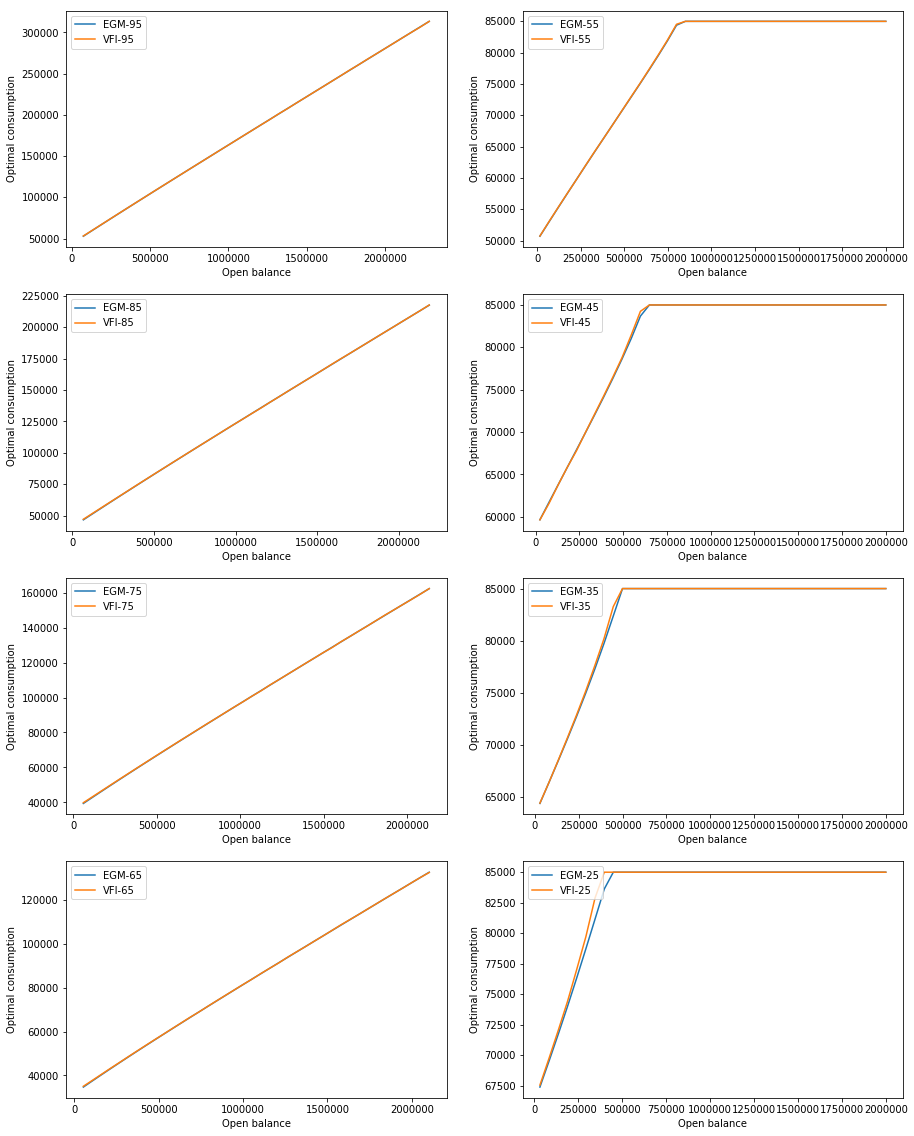

In [10]:
# Table names: Optimal_results_EGM, Optimal_results_EGM_25_63
# Table names: Optimal_results_VFI, Optimal_results_VFI_25_63

plt.figure(figsize=(15,20))

plt.subplot(4,2,1)
plt.plot(Optimal_results_EGM['M95'], Optimal_results_EGM['C95'])
plt.plot(Optimal_results_VFI['M95'], Optimal_results_VFI['C95'])
plt.legend(['EGM-95','VFI-95'], loc='upper left')
plt.xlabel('Open balance')
plt.ylabel('Optimal consumption')

plt.subplot(4,2,3)
plt.plot(Optimal_results_EGM['M85'], Optimal_results_EGM['C85'])
plt.plot(Optimal_results_VFI['M85'], Optimal_results_VFI['C85'])
plt.legend(['EGM-85','VFI-85'], loc='upper left')
plt.xlabel('Open balance')
plt.ylabel('Optimal consumption')

plt.subplot(4,2,5)
plt.plot(Optimal_results_EGM['M75'], Optimal_results_EGM['C75'])
plt.plot(Optimal_results_VFI['M75'], Optimal_results_VFI['C75'])
plt.legend(['EGM-75','VFI-75'], loc='upper left')
plt.xlabel('Open balance')
plt.ylabel('Optimal consumption')

plt.subplot(4,2,7)
plt.plot(Optimal_results_EGM['M65'], Optimal_results_EGM['C65'])
plt.plot(Optimal_results_VFI['M65'], Optimal_results_VFI['C65'])
plt.legend(['EGM-65','VFI-65'], loc='upper left')
plt.xlabel('Open balance')
plt.ylabel('Optimal consumption')

plt.subplot(4,2,2)
plt.plot(Optimal_results_EGM_25_63['M55'], Optimal_results_EGM_25_63['C55'])
plt.plot(Optimal_results_VFI_25_63['M55'], Optimal_results_VFI_25_63['C55'])
plt.legend(['EGM-55','VFI-55'], loc='upper left')
plt.xlabel('Open balance')
plt.ylabel('Optimal consumption')

plt.subplot(4,2,4)
plt.plot(Optimal_results_EGM_25_63['M45'], Optimal_results_EGM_25_63['C45'])
plt.plot(Optimal_results_VFI_25_63['M45'], Optimal_results_VFI_25_63['C45'])
plt.legend(['EGM-45','VFI-45'], loc='upper left')
plt.xlabel('Open balance')
plt.ylabel('Optimal consumption')

plt.subplot(4,2,6)
plt.plot(Optimal_results_EGM_25_63['M35'], Optimal_results_EGM_25_63['C35'])
plt.plot(Optimal_results_VFI_25_63['M35'], Optimal_results_VFI_25_63['C35'])
plt.legend(['EGM-35','VFI-35'], loc='upper left')
plt.xlabel('Open balance')
plt.ylabel('Optimal consumption')

plt.subplot(4,2,8)
plt.plot(Optimal_results_EGM_25_63['M25'], Optimal_results_EGM_25_63['C25'])
plt.plot(Optimal_results_VFI_25_63['M25'], Optimal_results_VFI_25_63['C25'])
plt.legend(['EGM-25','VFI-25'], loc='upper left')
plt.xlabel('Open balance')
plt.ylabel('Optimal consumption')

# plt.savefig('figure 1.1.png')

Text(0,0.5,'Optimal consumption')

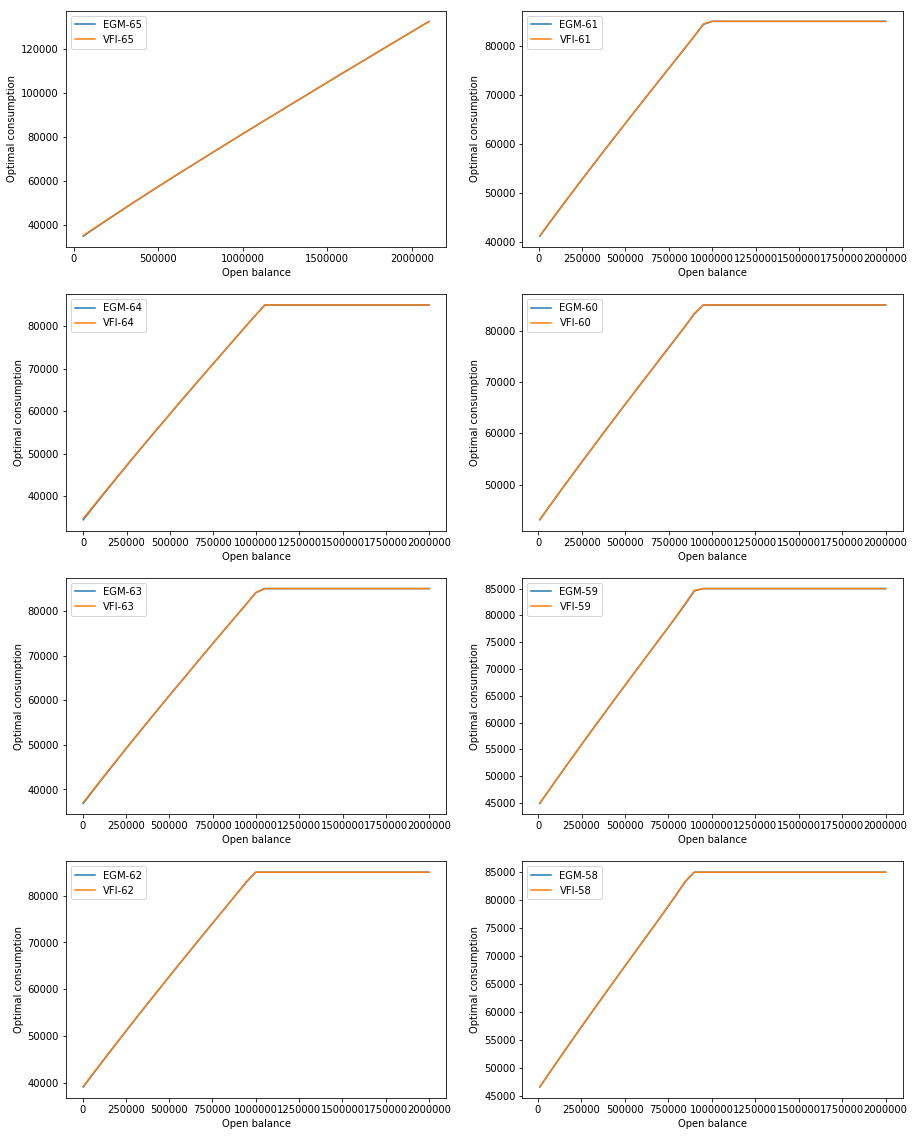

In [11]:
# Table names: Optimal_results_EGM, Optimal_results_EGM_25_63
# Table names: Optimal_results_VFI, Optimal_results_VFI_25_63

plt.figure(figsize=(15,20))

plt.subplot(4,2,1)
plt.plot(Optimal_results_EGM['M65'], Optimal_results_EGM['C65'])
plt.plot(Optimal_results_VFI['M65'], Optimal_results_VFI['C65'])
plt.legend(['EGM-65','VFI-65'], loc='upper left')
plt.xlabel('Open balance')
plt.ylabel('Optimal consumption')

plt.subplot(4,2,3)
plt.plot(Optimal_results_EGM_25_63['M64'], Optimal_results_EGM_25_63['C64'])
plt.plot(Optimal_results_VFI_25_63['M64'], Optimal_results_VFI_25_63['C64'])
plt.legend(['EGM-64','VFI-64'], loc='upper left')
plt.xlabel('Open balance')
plt.ylabel('Optimal consumption')

plt.subplot(4,2,5)
plt.plot(Optimal_results_EGM_25_63['M63'], Optimal_results_EGM_25_63['C63'])
plt.plot(Optimal_results_VFI_25_63['M63'], Optimal_results_VFI_25_63['C63'])
plt.legend(['EGM-63','VFI-63'], loc='upper left')
plt.xlabel('Open balance')
plt.ylabel('Optimal consumption')

plt.subplot(4,2,7)
plt.plot(Optimal_results_EGM_25_63['M62'], Optimal_results_EGM_25_63['C62'])
plt.plot(Optimal_results_VFI_25_63['M62'], Optimal_results_VFI_25_63['C62'])
plt.legend(['EGM-62','VFI-62'], loc='upper left')
plt.xlabel('Open balance')
plt.ylabel('Optimal consumption')

plt.subplot(4,2,2)
plt.plot(Optimal_results_EGM_25_63['M61'], Optimal_results_EGM_25_63['C61'])
plt.plot(Optimal_results_VFI_25_63['M61'], Optimal_results_VFI_25_63['C61'])
plt.legend(['EGM-61','VFI-61'], loc='upper left')
plt.xlabel('Open balance')
plt.ylabel('Optimal consumption')

plt.subplot(4,2,4)
plt.plot(Optimal_results_EGM_25_63['M60'], Optimal_results_EGM_25_63['C60'])
plt.plot(Optimal_results_VFI_25_63['M60'], Optimal_results_VFI_25_63['C60'])
plt.legend(['EGM-60','VFI-60'], loc='upper left')
plt.xlabel('Open balance')
plt.ylabel('Optimal consumption')

plt.subplot(4,2,6)
plt.plot(Optimal_results_EGM_25_63['M59'], Optimal_results_EGM_25_63['C59'])
plt.plot(Optimal_results_VFI_25_63['M59'], Optimal_results_VFI_25_63['C59'])
plt.legend(['EGM-59','VFI-59'], loc='upper left')
plt.xlabel('Open balance')
plt.ylabel('Optimal consumption')

plt.subplot(4,2,8)
plt.plot(Optimal_results_EGM_25_63['M58'], Optimal_results_EGM_25_63['C58'])
plt.plot(Optimal_results_VFI_25_63['M58'], Optimal_results_VFI_25_63['C58'])
plt.legend(['EGM-58','VFI-58'], loc='upper left')
plt.xlabel('Open balance')
plt.ylabel('Optimal consumption')

# plt.savefig('EGMvsVFI (only consumption) 58-65.png')

Text(0,0.5,'Optimal consumption')

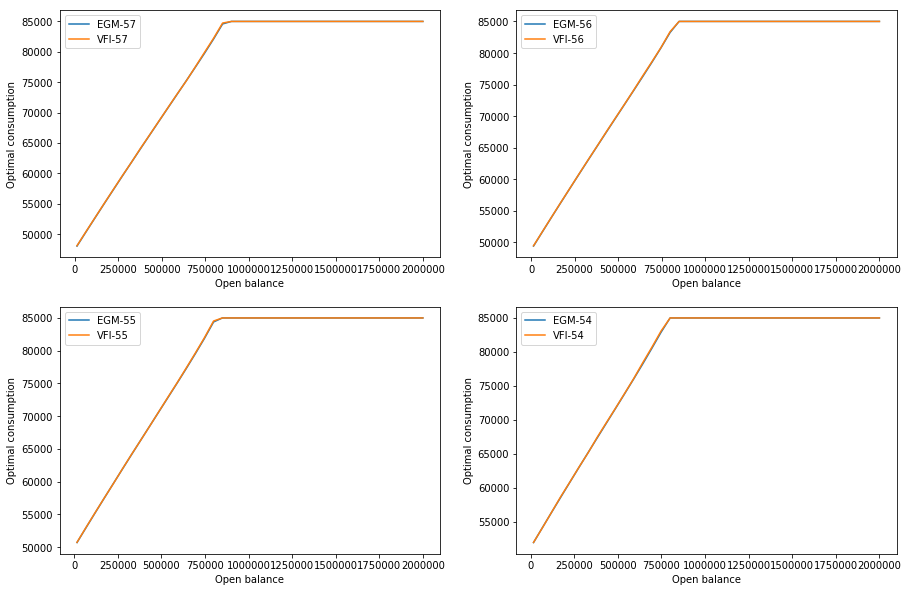

In [12]:
# Table names: Optimal_results_EGM, Optimal_results_EGM_25_63
# Table names: Optimal_results_VFI, Optimal_results_VFI_25_63

plt.figure(figsize=(15,10))

plt.subplot(2,2,1)
plt.plot(Optimal_results_EGM_25_63['M57'], Optimal_results_EGM_25_63['C57'])
plt.plot(Optimal_results_VFI_25_63['M57'], Optimal_results_VFI_25_63['C57'])
plt.legend(['EGM-57','VFI-57'], loc='upper left')
plt.xlabel('Open balance')
plt.ylabel('Optimal consumption')

plt.subplot(2,2,2)
plt.plot(Optimal_results_EGM_25_63['M56'], Optimal_results_EGM_25_63['C56'])
plt.plot(Optimal_results_VFI_25_63['M56'], Optimal_results_VFI_25_63['C56'])
plt.legend(['EGM-56','VFI-56'], loc='upper left')
plt.xlabel('Open balance')
plt.ylabel('Optimal consumption')

plt.subplot(2,2,3)
plt.plot(Optimal_results_EGM_25_63['M55'], Optimal_results_EGM_25_63['C55'])
plt.plot(Optimal_results_VFI_25_63['M55'], Optimal_results_VFI_25_63['C55'])
plt.legend(['EGM-55','VFI-55'], loc='upper left')
plt.xlabel('Open balance')
plt.ylabel('Optimal consumption')

plt.subplot(2,2,4)
plt.plot(Optimal_results_EGM_25_63['M54'], Optimal_results_EGM_25_63['C54'])
plt.plot(Optimal_results_VFI_25_63['M54'], Optimal_results_VFI_25_63['C54'])
plt.legend(['EGM-54','VFI-54'], loc='upper left')
plt.xlabel('Open balance')
plt.ylabel('Optimal consumption')


# plt.savefig('EGMvsVFI (only consumption) 57-54.png')